Using TensorFlow backend.
C:\Users\Precisit\Anaconda3\envs\NaturalLanguageToCode\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Precisit\Anaconda3\envs\NaturalLanguageToCode\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Precisit\Anaconda3\envs\NaturalLanguageToCode\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

nb_tags: 46ntags: {'VBZ', 'MD', '-LRB-', 'PDT', 'VB', 'JJR', ',', 'EX', 'POS', 'RB', 'WDT', 'WRB', 'CD', 'SYM', '#', 'DT', 'WP', 'UH', ':', 'VBD', 'RBS', 'TO', 'RP', 'VBG', '.', 'VBP', 'NNP', 'WP$', '-NONE-', 'RBR', 'JJ', '-RRB-', 'VBN', '``', 'NNPS', 'LS', 'FW', 'PRP$', 'PRP', 'NNS', '$', "''", 'NN', 'CC', 'IN', 'JJS'}
978
Maximum sentence length: 92


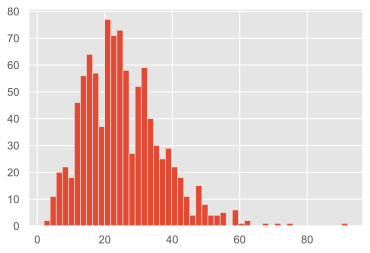

<Figure size 432x288 with 0 Axes>

In [1]:
import nltk
from nltk.corpus import treebank
from tensorflow import keras
from keras import Input, regularizers
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import *
from keras.layers import Dense, Dropout, Activation, LSTM, Flatten
from keras.preprocessing import sequence
from keras_preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Convolution1D, MaxPooling1D, Conv1D
from keras.utils import plot_model
from keras.models import load_model, Model
from keras.callbacks import ModelCheckpoint
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import recall_score,precision_score,classification_report,accuracy_score,confusion_matrix,f1_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

import itertools
import pickle
import pandas as pd
import re
import numpy as np
np.random.seed(1337)  # for reproducibility
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


In [ ]:
#================================================================================================#
#========================Proccesing the data for the models======================================#
nltk.download('treebank')
sentences = treebank.tagged_sents()
sentences = sentences[:len(sentences) //4]
tags = set([
    tag for sentence in treebank.tagged_sents()
    for _, tag in sentence
])
print('nb_tags: %sntags: %s' % (len(tags), tags)) #number of tags we got
print(len(sentences))

train_test_cutoff = int(.80 * len(sentences))
training_sentences = sentences[:train_test_cutoff]
testing_sentences = sentences[train_test_cutoff:]
train_val_cutoff = int(.25 * len(training_sentences))
validation_sentences = training_sentences[:train_val_cutoff]
training_sentences = training_sentences[train_val_cutoff:]

#These properties could include information about
# previous and next words as well as prefixes and suffixes.
def add_basic_features(sentence_terms, index):
    """ Compute some very basic word features.
        :param sentence_terms: [w1, w2, ...]
        :type sentence_terms: list
        :param index: the index of the word
        :type index: int
        :return: dict containing features
        :rtype: dict
    """
    term = sentence_terms[index]
    return {
        'nb_terms': len(sentence_terms),
        'term': term,
        'is_first': index == 0,
        'is_last': index == len(sentence_terms) - 1,
        'is_capitalized': term[0].upper() == term[0],
        'is_all_caps': term.upper() == term,
        'is_all_lower': term.lower() == term,
        'prefix-1': term[0],
        'prefix-2': term[:2],
        'prefix-3': term[:3],
        'suffix-1': term[-1],
        'suffix-2': term[-2:],
        'suffix-3': term[-3:],
        'prev_word': '' if index == 0 else sentence_terms[index - 1],
        'next_word': '' if index == len(sentence_terms) - 1 else sentence_terms[index + 1]
    }

def untag(tagged_sentence):
    """
    Remove the tag for each tagged term.
    :param tagged_sentence: a POS tagged sentence
    :type tagged_sentence: list
    :return: a list of tags
    :rtype: list of strings
    """
    return [w for w, _ in tagged_sentence]

def transform_to_dataset(tagged_sentences):
    """
    Split tagged sentences to X and y datasets and append some basic features.
    :param tagged_sentences: a list of POS tagged sentences
    :param tagged_sentences: list of list of tuples (term_i, tag_i)
    :return:
    """
    X, y = [], []
    for pos_tags in tagged_sentences:
            for index, (term, class_) in enumerate(pos_tags):
                X.append(add_basic_features(untag(pos_tags), index))
                y.append(class_)
    return X, y

X_train, y_train = transform_to_dataset(training_sentences)
X_test, y_test = transform_to_dataset(testing_sentences)
X_val, y_val = transform_to_dataset(validation_sentences)

#Our neural network takes vectors as inputs, so we need to convert our dict features to vectors.
# Fit our DictVectorizer with our set of features
dict_vectorizer = DictVectorizer(sparse=False)
dict_vectorizer.fit(X_train + X_test + X_val)
# Convert dict features to vectors
preX_train = X_train
X_train = dict_vectorizer.transform(X_train)
X_test = dict_vectorizer.transform(X_test)
X_val = dict_vectorizer.transform(X_val)

# Fit LabelEncoder with our list of classes
label_encoder = LabelEncoder()
label_encoder.fit(y_train + y_test + y_val)
# Encode class values as integers
prey_train = y_train
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

# Convert integers to dummy variables (one hot encoded)
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)

def untagger(tagged_sentences):
    X = []
    for pos_tags in tagged_sentences:
                X.append(untag(pos_tags))
    return X
simple_train_sentences = untagger(training_sentences)

#Plot sentences distributed by length
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()
plt.savefig('sizeOfWords.png', dpi = 300, bbox_inches='tight')

maxlen = max([len(s) for s in sentences])
print ('Maximum sentence length:', maxlen)

In [3]:
#================================================================================================#
#========================Building a model======================================#


In [3]:
def build_model(input_dim, hidden_neurons, output_dim):
    model = Sequential([
        Dense(hidden_neurons, input_dim=input_dim),
        Activation('relu'),
        Dropout(0.2),
        Dense(hidden_neurons),
        Activation('relu'),
        Dropout(0.2),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_params = {
    'build_fn': build_model,
    'input_dim': X_train.shape[1],
    'hidden_neurons': 512,
    'output_dim': y_train.shape[1],
    'epochs': 5,
    'batch_size': 256,
    'verbose': 1,
    'validation_data': (X_val, y_val),
    'shuffle': True
}

clf = KerasClassifier(**model_params)
hist = clf.fit(X_train, y_train) #trains it
clf.model.save('keras_mlp.h5') #Save trained model to keras_mlp.h5
y_pred = clf.model.predict(X_test, verbose=1).argmax(-1)
y_true = y_test.argmax(-1)


Train on 14560 samples, validate on 4970 samples
Epoch 1/5
14560/14560 [==============================] - 27s 2ms/step - loss: 1.9216 - accuracy: 0.5411 - val_loss: 0.6465 - val_accuracy: 0.8634

In [ ]:
#================================================================================================#
#========================Building a LSTM model======================================#
#https://medium.com/@sabber/classifying-yelp-review-comments-using-cnn-lstm-and-visualize-word-embeddings-part-2-ca137a42a97d

In [ ]:
#class AttentionLayer(object):
#   pass
def create_lstm_model():
    model_lstm = Sequential()
    model_lstm.add(Embedding(X_train.shape[1], 100, input_length=20323))
    #model_cnn.add(Conv1D(num_filters, kernel_size= 3, activation='relu', kernel_regularizer=regularizers.l2(3)))
    model_lstm.add(Dropout(0.2))
    #model_conv.add(Conv1D(64, 5, activation='relu'))
    model_lstm.add(MaxPooling1D())
    #model_conv.add(AttentionLayer())
    model_lstm.add(LSTM(100))
    #model_lstm.add(Flatten())
    model_lstm.add(Dropout(0.2))
    model_lstm.add(Dense(43, activation='softmax')) #Or sigmoid
    model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model_lstm

model_lstm = create_lstm_model()
model_lstm.fit(X_train, y_train, validation_split=0.4, validation_data = (X_val, y_val), epochs = 2)
model_lstm.model.save('lstm.h5') #Save trained model to keras_mlp.h5



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 8736 samples, validate on 5824 samples
Epoch 1/2
5920/8736 [===================>..........] - ETA: 10:10 - loss: 0.0954 - accuracy: 0.9767  

In [ ]:
#================================================================================================#
#========================Building a CNN model======================================#
#https://www.kaggle.com/hamishdickson/cnn-for-sentence-classification-by-yoon-kim/data

In [4]:
num_filters = 100
embedding_dim = 200
sequence_length = 46

inputs_2 = Input(shape=(X_train.shape[1],), dtype='int32')

#Version 1: val_loss 0.26, val_acc 0.91

def create_cnn_model():
    model_cnn = Sequential()
    model_cnn.add(Embedding(X_train.shape[1], 100, input_length=20323))
    model_cnn.add(Conv1D(num_filters, kernel_size= 3, activation='relu', kernel_regularizer=regularizers.l2(3)))
    #model_cnn.add(Conv1D(num_filters, kernel_size=(4), activation='relu', kernel_regularizer=regularizers.l2(3)))
    #model_cnn.add(Conv1D(num_filters, kernel_size=(5), activation='relu', kernel_regularizer=regularizers.l2(3)))
    model_cnn.add(MaxPooling1D())
    #model_cnn.add(MaxPooling1D(pool_size=4))
    #model_cnn.add(MaxPooling1D(pool_size=5))
    model_cnn.add(Flatten())
    model_cnn.add(Dropout(0.2))
    model_cnn.add(Dense(43, activation='softmax')) #Or sigmoid
    model_cnn.compile(loss='binary_crossentropy', optimizer='adam',    metrics=['accuracy'])
    return model_cnn

model_cnn = create_cnn_model()
print(model_cnn.summary())
hist_2 = model_cnn.fit(X_train, y_train, validation_split=0.4, epochs = 2,validation_data =(X_val,y_val), batch_size=10)
model_cnn.model.save('cnn.h5') #Save trained model to keras_mlp.h5



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20323, 100)        2032300   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20321, 100)        30100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10160, 100)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1016000)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1016000)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 43)                43688043  
Total params: 45,750,443
Trainable params: 45,750,443
Non-trainable params: 0
_________________________________________

C:\Users\Precisit\Anaconda3\envs\NaturalLanguageToCode\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


In [ ]:
#================================================================================================#
#========================Building a RF model======================================#
#https://blog.goodaudience.com/introduction-to-random-forest-algorithm-with-python-9efd1d8f0157
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [10]:
# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
#bootstrap = [True, False]
# Create the random grid
#random_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth': max_depth,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'bootstrap': bootstrap}
#print(random_grid)


# Use the random grid to search for best hyperparameters
# First create the base model to tune
#rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
#rf_random.fit(X_train, y_train)
#print(rf_random.best_params_)

#{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
#Fitting 3 folds for each of 5 candidates, totalling 15 fits
#{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': False}

RF_model = RandomForestClassifier(n_estimators = 1000, min_samples_split = 10, min_samples_leaf = 1, max_features = 'auto', max_depth =  80, bootstrap = False)
histRF = RF_model.fit(X_train, y_train)
RF_predictions = RF_model.predict(X_test)
print('Parameters currently in use:\n')
print(RF_model.get_params())

Parameters currently in use:

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 80, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [17]:
#import pickle

with open('rf', 'wb') as modelfile:
    pickle.dump(RF_model, modelfile)

#RF_model.model.save('rf.h5')

OSError: [Errno 28] No space left on device

In [ ]:
#================================================================================================#
#========================Visulize the result======================================#

In [20]:
def plot_model_performance(train_loss, train_acc, train_val_loss, train_val_acc):
    """ Plot model loss and accuracy through epochs. """
    blue= '#34495E'
    green = '#2ECC71'
    orange = '#E23B13'
    # plot model loss
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))
    ax1.plot(range(1, len(train_loss) + 1), train_loss, blue, linewidth=5, label='training')
    ax1.plot(range(1, len(train_val_loss) + 1), train_val_loss, green, linewidth=5, label='validation')
    ax1.set_xlabel('# epoch')
    ax1.set_ylabel('loss')
    ax1.tick_params('y')
    ax1.legend(loc='upper right', shadow=False)
    ax1.set_title('Model loss through #epochs', color=orange, fontweight='bold')
    # plot model accuracy
    ax2.plot(range(1, len(train_acc) + 1), train_acc, blue, linewidth=5, label='training')
    ax2.plot(range(1, len(train_val_acc) + 1), train_val_acc, green, linewidth=5, label='validation')
    ax2.set_xlabel('# epoch')
    ax2.set_ylabel('accuracy')
    ax2.tick_params('y')
    ax2.legend(loc='lower right', shadow=False)
    ax2.set_title('Model accuracy through #epochs', color=orange, fontweight='bold')

In [21]:
plot_model_performance(
        train_loss=histRF.history.get('loss', []),
        train_acc=histRF.history.get('accuracy', []),
        train_val_loss=histRF.history.get('val_loss', []),
        train_val_acc=histRF.history.get('val_accuracy', [])
    )
score = accuracy_score(y_test ,RF_predictions)
print(score)


plot_model_performance(
        train_loss=hist.history.get('loss', []),
        train_acc=hist.history.get('accuracy', []),
        train_val_loss=hist.history.get('val_loss', []),
        train_val_acc=hist.history.get('val_accuracy', [])
    )
score = clf.score(X_test, y_test)
print(score)

AttributeError: 'RandomForestClassifier' object has no attribute 'history'

In [ ]:
#================================================================================================#
#========================Visulize the model======================================#

In [27]:
plot_model(model_lstm.model, to_file='model.png', show_shapes=True)


ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [36]:
con_tags = {'$',',','-NONE-','JJR','NNS','SYM','TO','UH','VBD','VBN','VBZ','WP$'}
def plot_confusion_matrix(f1,
                          cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    plt.figure(figsize=(10, 10))
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}; f1-score={:0.4f}'.format(accuracy, misclass, f1))

model = load_model("cnn.h5")
y_predCNN = model.predict(X_test, verbose=1).argmax(-1)
cnf_matrix = confusion_matrix(y_test , y_predCNN)
plot_confusion_matrix(f1_score(y_test, y_predCNN, average='macro'), cnf_matrix, target_names=con_tags, title='Confusion matrix', normalize=False)

5061/5061 [==============================] - 65s 13ms/step

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [ ]:
def plot_acc():
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_acc()

In [ ]:
name='model'
print('\n---- Result of {} ----\n'.format(name))
print(classification_report(y_true, y_pred, digits=4))

In [6]:
#Test the accuracies
cnn = load_model('cnn.h5')
lossC, accC = cnn.evaluate(X_test, y_test)
print('CNN Test loss: ', lossC)
print('CNN Test accuracy: ', accC)

5061/5061 [==============================] - 76s 15ms/step

In [5]:
lstm = load_model('lstm.h5')
lossL, accL = lstm.evaluate(X_test, y_test)
print('LSTM Test loss: ', lossL)
print('LSTM Test accuracy: ', accL)

OSError: Unable to open file (unable to open file: name = 'lstm.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [13]:
rf = load_model('rf.h5')
lossRF, accRF = rf.evaluate(X_test, y_test)
print('RF Test loss: ', lossRF)
print('RF Test accuracy: ', accRF)
#score = accuracy_score(y_test ,RF_predictions)
#print(score)

OSError: Unable to open file (unable to open file: name = 'rf.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
plt.plot(hist_2.history['accuracy'])
plt.plot(hist_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(hist_2.history['loss'])
plt.plot(hist_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

